<a href="https://colab.research.google.com/github/alvinrach/24-NLP-LSTM-News-Title-Classification/blob/main/NLP_LSTM_News_Title_Classification_Alvin_Rachmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alvin Rachmat**

**NLP-LSTM : News Title Classification**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

!pip install contractions
import re
import contractions
import nltk
nltk.download('stopwords')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

     |████████████████████████████████| 327kB 35.3MB/s 
     |████████████████████████████████| 286kB 46.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85397 sha256=f99bf96052264a1dc23032271289abd339edd21b071f0a553f10998ba56548cc
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
url = 'https://drive.google.com/file/d/1GRg1E-3eYkTwMkaFEy4khaTSeoboSOw5/view?usp=sharing'
dwn_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
d = pd.read_excel(dwn_url)
len(d)

65535

Just use some of the data, since there is a bug of LSTM which in a certain amount point of data, will result error (in my plain jupyter) or will result in extremely significant raise of train time (colab)
https://github.com/tensorflow/tensorflow/issues/33721

In [3]:
d=d.iloc[:52000,:]
d = d.drop('No',1)
d

,News Title,Category
0,Google+ rolls out 'Stories' for tricked out ph...,Technology
1,Dov Charney's Redeeming Quality,Business
2,White God adds Un Certain Regard to the Palm Dog,Entertainment
3,"Google shows off Androids for wearables, cars,...",Technology
4,China May new bank loans at 870.8 bln yuan,Business
...,...,...
51995,MH370: poor conditions hamper search for debri...,Business
51996,"Tech stocks, Nasdaq take a tumble",Business
51997,Climate Action Plan - Strategy to Cut Methane ...,Business
51998,Breakthrough: Living materials created by MIT ...,Technology


In [4]:
# Cleaning the texts
def txtprocess(txt):
    # Lower the texts
    txt = str(txt).lower()
    # Remove contractions
    txt = contractions.fix(txt)
    
    # Just pick the alphabet
    txt = re.sub(r'[^a-zA-Z]', ' ', txt)
    # Fix unnecessary space
    txt = re.sub(' +', ' ', txt)
    
    txt = ' '.join(txt.split())
    
    return txt

d['News Title'] = d['News Title'].apply(txtprocess)

In [5]:
# Cleaning stopwords. Omit the negative maker words (I found this quite effective on this case)
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

def remove_stopwords(txt):
    no_stopword_txt = [w for w in txt.split() if not w in stop_words]
    return ' '.join(no_stopword_txt)

d['News Title'] = d['News Title'].apply(lambda x: remove_stopwords(x))

In [6]:
# Create new table consists of dummified label
category = pd.get_dummies(d.Category)
d_new = pd.concat([d, category], axis=1)
d_new = d_new.drop('Category',1)
d_new

,News Title,Business,Entertainment,Medical,Technology
0,google rolls stories tricked photo playback,0,0,0,1
1,dov charney redeeming quality,1,0,0,0
2,white god adds un certain regard palm dog,0,1,0,0
3,google shows androids wearables cars tvs,0,0,0,1
4,china may new bank loans bln yuan,1,0,0,0
...,...,...,...,...,...
51995,mh poor conditions hamper search debris indian...,1,0,0,0
51996,tech stocks nasdaq take tumble,1,0,0,0
51997,climate action plan strategy cut methane emiss...,1,0,0,0
51998,breakthrough living materials created mit scie...,0,0,0,1


In [7]:
# Get data as array
title = d_new['News Title'].values
label = d_new[category.columns].values
title_train, title_test, y_train, y_test = train_test_split(title, label, test_size=0.2, random_state=42)

In [8]:
# Mark the uncategorized words as -
# Don't let the test data be fitted also (dont let test data know the train data)
tokenizer = Tokenizer(num_words=None, oov_token='-')
tokenizer.fit_on_texts(title_train)
 
sekuens_train = tokenizer.texts_to_sequences(title_train)
sekuens_test = tokenizer.texts_to_sequences(title_test)
 
padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [9]:
# As reminder to the shape of the padded_train
sekuens_train[:5], padded_train

([[2221, 1074, 10720, 216, 4121, 110],
  [512, 1661, 439, 1572, 6373, 7913, 6374],
  [15, 371, 26, 2080, 500],
  [1492, 13, 36, 5022, 1761, 3917, 145],
  [22, 21, 67, 34, 540, 501, 10721, 717, 2339, 2589]],
 array([[   0,    0,    0, ...,  216, 4121,  110],
        [   0,    0,    0, ..., 6373, 7913, 6374],
        [   0,    0,    0, ...,   26, 2080,  500],
        ...,
        [   0,    0,    0, ...,  107,  111,  222],
        [   0,    0,    0, ..., 1293, 7120,  410],
        [   0,    0,    0, ..., 1062,  883,   14]], dtype=int32))

In [10]:
# Length of each tokenized data
# The size of input nodes, or input length in embedding layer (if use flatten after that) (use train)
len(padded_train[1]), len(padded_test[1])

(103, 13)

In [11]:
## Length of the data
len(padded_train), len(padded_test)

(41600, 10400)

In [20]:
# Check word index of the tokenized data
print(dict(list(tokenizer.word_index.items())[:30]))

{'-': 1, 'new': 2, 'us': 3, 'not': 4, 'google': 5, 'apple': 6, 'video': 7, 'says': 8, 'first': 9, 'samsung': 10, 'may': 11, 'one': 12, 'facebook': 13, 'report': 14, 'microsoft': 15, 'star': 16, 'watch': 17, 'galaxy': 18, 'china': 19, 'day': 20, 'kardashian': 21, 'kim': 22, 'season': 23, 'review': 24, 'but': 25, 'deal': 26, 'million': 27, 'game': 28, 'amazon': 29, 'world': 30}


In [ ]:
# Richness of the words
len(tokenizer.word_index)

21946

https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046

In [ ]:
# to decide LSTM hidden nodes
hidden_nodes = int(2/3 * (len(padded_train[1]) * len(category.columns)))
hidden_nodes

274

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542

In [ ]:
# another way to decide LSTM hidden nodes
# alpha 5-10, some say its 2-10
alpha = 10
hidden_nodes = int(len(padded_train)/(alpha*(len(padded_train[1]) * len(category.columns))))
hidden_nodes

10

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

https://forums.fast.ai/t/embedding-layer-size-rule/50691/13

In [ ]:
# Let the indicator that has been scrutinized kept as markdown
# Note for myself: Next time, document all the tries with a train-val-loss-accuracy plot, each trial attach the model code
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=500),#(input_dim=len(tokenizer.word_index)+2, output_dim=500),
    tf.keras.layers.LSTM(hidden_nodes, dropout=0.96),#, kernel_regularizer=tf.keras.regularizers.l2(0.01)),#, recurrent_dropout=0.3),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(56, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
set_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

history = model.fit(padded_train, y_train, epochs=60, batch_size=128,
                    validation_data=(padded_test, y_test), callbacks=[set_callback], verbose=2)

Epoch 1/60
325/325 - 48s - loss: 1.0929 - accuracy: 0.5242 - val_loss: 0.5951 - val_accuracy: 0.7986
Epoch 2/60
325/325 - 45s - loss: 0.5551 - accuracy: 0.8039 - val_loss: 0.3654 - val_accuracy: 0.8832
Epoch 3/60
325/325 - 45s - loss: 0.4052 - accuracy: 0.8603 - val_loss: 0.3051 - val_accuracy: 0.8995
Epoch 4/60
325/325 - 45s - loss: 0.3438 - accuracy: 0.8820 - val_loss: 0.2756 - val_accuracy: 0.9075
Epoch 5/60
325/325 - 45s - loss: 0.3003 - accuracy: 0.8969 - val_loss: 0.2587 - val_accuracy: 0.9127
Epoch 6/60
325/325 - 45s - loss: 0.2741 - accuracy: 0.9056 - val_loss: 0.2467 - val_accuracy: 0.9173
Epoch 7/60
325/325 - 45s - loss: 0.2549 - accuracy: 0.9122 - val_loss: 0.2424 - val_accuracy: 0.9194
Epoch 8/60
325/325 - 45s - loss: 0.2353 - accuracy: 0.9192 - val_loss: 0.2359 - val_accuracy: 0.9217
Epoch 9/60
325/325 - 45s - loss: 0.2245 - accuracy: 0.9217 - val_loss: 0.2313 - val_accuracy: 0.9242
Epoch 10/60
325/325 - 45s - loss: 0.2135 - accuracy: 0.9269 - val_loss: 0.2307 - val_accura

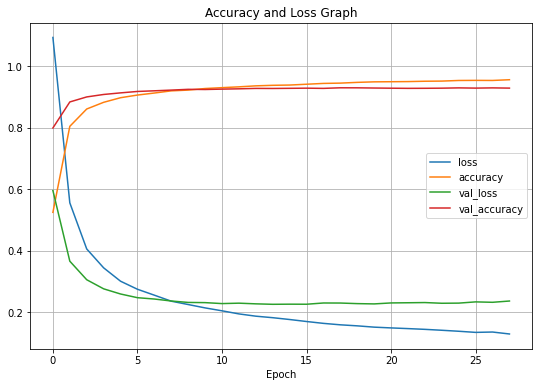

In [ ]:
# Plotting loss and accuracy, train and validation, each epoch
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid()